In [5]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week6_outro/submit.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.8_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.8) ...
Setting up xvfb (2:1.19.6-1ubuntu4.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [8]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum 
import numpy as np 
np.set_printoptions(precision = 3)
np.set_printoptions(suppress = True )
import pandas as pd 
import matplotlib.pyplot as plt
 

In [23]:
class BernoulliBandit:
  def __init__(self,n_actions=5):
    self._probs = np.random.random(n_actions)
  @property
  def action_count(self):
    return len(self._probs)
  def pull(self,action):
    if np.any(np.random.random() > self._probs[action]):
        return 0.0
    return 1.0
  def optimal_reward(self):
    return np.max(self._probs)
  def step(self):
    pass
  def reset(self):
    """ """


In [13]:
class AbstractAgent(metaclass=ABCMeta):
  def init_actions(self,n_actions):
    self._successes = np.zeros(n_actions)+1
    self._failures = np.zeros(n_actions)+1
    self._total_pulls = 0
  @abstractmethod
  def  get_action(self):
    pass
  def update(self,action,reward):
    self._total_pulls += 1
    if reward == 1:
      self._successes[action] += 1
    else:
      self._failures[action] += 1
  @property
  def name(self):
    return self.__class__.__name__  
class RandomAgent(AbstractAgent):
  def get_action(self):
    return np.random.randint(0,len(self._successes))



In [30]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon

    def get_action(self):
        prob = self._successes/(self._successes+self._failures)

        x_hat = np.argmax(prob)
        if np.random.random() < self._epsilon:
            x_hat = np.random.randint(0, len(self._successes))
        return x_hat

    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)




In [32]:
class UCBAgent(AbstractAgent):
    def __init__(self, gamma=0.01):
        self._gamma = gamma

    def get_action(self):
        # <YOUR CODE>
        alpha = self._successes
        beta = self._failures
        t = self._total_pulls

        w = alpha/(alpha+beta) + self._gamma*np.sqrt(2*np.log(t)/(alpha+beta))

        return np.argmax(w)

    @property
    def name(self):
        return self.__class__.__name__ + "(gamma={})".format(self._gamma)       

In [27]:
class ThompsonSamplingAgent(AbstractAgent):
  def get_action(self):
    theta = np.random.beta(self._successes+1,self._failures+1)
    return np.argmax(theta)

In [40]:
from collections import OrderedDict

def get_regret(env, agents, n_steps=5000, n_trails=50):
    scores = OrderedDict({
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    })

    for trial in range(n_trails):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trails

    return scores

def plot_regret(agents, scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()               

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


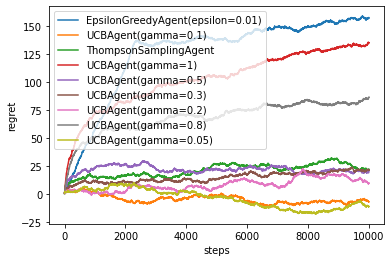

In [42]:
agents = [
        EpsilonGreedyAgent(),
        UCBAgent(0.1),
        ThompsonSamplingAgent(),
        UCBAgent(1),
        UCBAgent(0.5),
        UCBAgent(0.3),
        UCBAgent(0.2),
        UCBAgent(0.8),
        UCBAgent(0.05),  
]
regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trails=10)
plot_regret(agents, regret)